In [1]:
import numpy as np
from sklearn import datasets

from sklearn.decomposition import PCA
from resurces.FDA import FDA, KPCA_FDA

from sklearn.model_selection import GridSearchCV

from sklearn.neural_network import MLPClassifier

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display

from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, make_scorer

from collections import Counter

from imblearn.over_sampling import RandomOverSampler

#importazione del Dataset

lfw_people = datasets.fetch_lfw_people(min_faces_per_person=100, resize=0.45)
face_data = lfw_people['data']
face_images = lfw_people['images']
face_tnames = lfw_people['target_names']
face_targets = lfw_people['target']

random_state = 19990704 #np.random.randint(0, 100000)
print('random_seed = ', random_state)
test_p = 0.4
val_p = 0.25  # Percentuale di dati di X_trainval da usare come validation set

X_trainval, X_test, y_trainval, y_test, _, img_test = train_test_split(face_data, face_targets, face_images, test_size=test_p, random_state=random_state, shuffle=True)

display(pd.DataFrame({'X_trainval': X_trainval.shape, 'X_test': X_test.shape}, index=['N. sanmples', 'N.features']))

ros = RandomOverSampler(random_state= random_state)
X_trainval_ros, y_trainval_ros = ros.fit_resample(X_trainval, y_trainval)

random_seed =  19990704


,X_trainval,X_test
N. sanmples,684,456
N.features,2352,2352


In [2]:
#normal
n_components_pca = X_trainval.shape[0] - face_tnames.shape[0]
pca = PCA(n_components= n_components_pca)
pca_data = pca.fit_transform(X_trainval)

# oversapled data
n_components_pca_ros = X_trainval_ros.shape[0] - face_tnames.shape[0]
pca_ros = PCA(n_components= n_components_pca_ros)
pca_data_ros = pca_ros.fit_transform(X_trainval_ros)

#normal
n_components_fda = face_tnames.shape[0]-1
fda = FDA(n_components_fda)
fda.fit(pca_data, y_trainval)
fda_data = fda.transform(pca_data)

#oversampled
fda_ros = FDA(n_components_fda)
fda_ros.fit(pca_data_ros, y_trainval_ros)
fda_data_ros = fda_ros.transform(pca_data_ros)

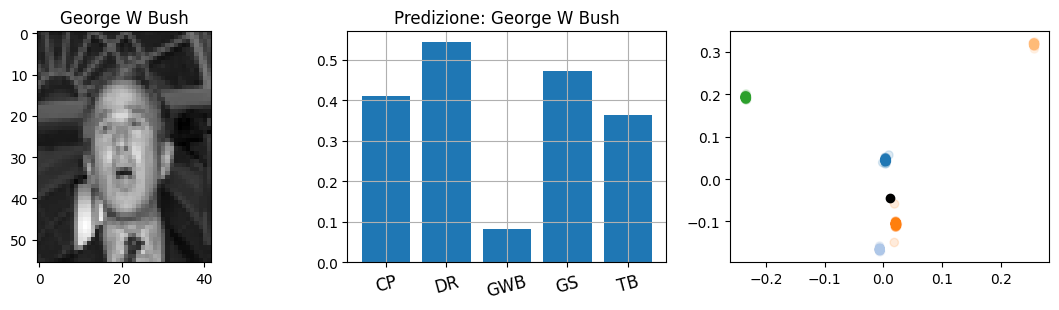

In [3]:
face_tnames_short = []
for name in face_tnames:
    name_split = name.split(' ')
    nm = ''
    for word in name_split:
        nm = nm + word[0]
    face_tnames_short.append(nm)

n_randsamples = 1
ind_test_rand = np.random.choice(len(face_targets), n_randsamples, replace=False)

rand_faces = face_data[ind_test_rand, :]
rand_targets = face_targets[ind_test_rand]

y_pred_rand_faces, rand_faces_decision = fda._predict_element(pca.transform(rand_faces))

mean = np.mean(rand_faces_decision)

for i in range(n_randsamples):
    fig, axs = plt.subplots(1, 3, figsize=(14, 3))
    ii = ind_test_rand[i]
    face_ii = face_images[ii]
    
    axs[0].imshow(face_ii, cmap=plt.cm.gray)
    axs[0].set_title('{}'.format(face_tnames[face_targets[ii]]))
    
    axs[1].bar(np.arange(len(face_tnames)), rand_faces_decision)
    axs[1].grid()
    axs[1].set_xticks(np.arange(len(face_tnames)))
    axs[1].set_xticklabels(face_tnames_short,
                           rotation=15,
                           fontsize=12
                          )
    axs[1].set_title('Predizione: {}'.format(face_tnames[y_pred_rand_faces]))

fda_face = fda.transform(pca.transform(rand_faces))

class_colors = [plt.cm.tab20.colors[c] for c in y_trainval]
axs[2].scatter(fda_data[:,0], fda_data[:,1], c=class_colors, alpha=0.15)
axs[2].scatter(fda_face[:,0], fda_face[:,1], c='black', alpha=1)

    
plt.show()

,Accuracy,Precision,Recall,F1
Training Set,1.000000,1.000000,1.000000,1.000000
Test Set,0.767544,0.766413,0.767544,0.763882
Oversampling Training Set,1.000000,1.000000,1.000000,1.000000
Oversampling Test Set,0.760965,0.755459,0.760965,0.756709


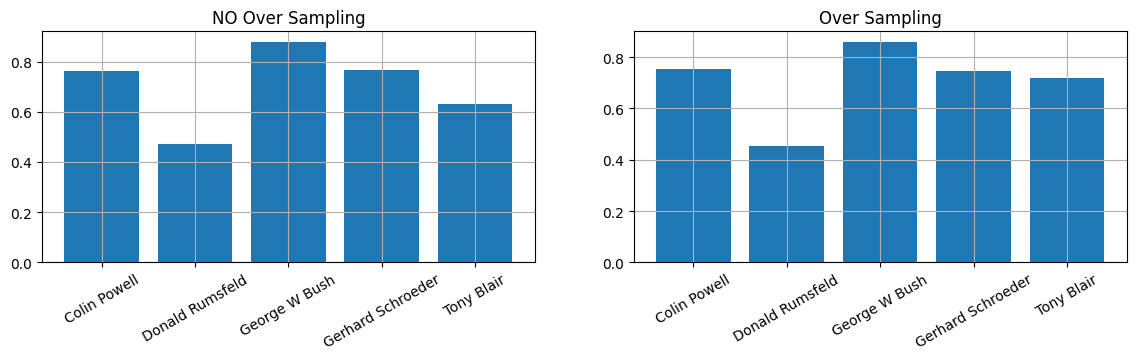

In [7]:
#Valutazione del dataset usato per il training
y_pred_trainval = fda.predict(pca_data)
y_pred_trainval_ros = fda_ros.predict(pca_data_ros)

#valutazine del dataset nuovo
pca_X_test = pca.transform(X_test)
pca_X_test_ros = pca_ros.transform(X_test)

y_pred = fda.predict(pca_X_test)
y_pred_ros = fda_ros.predict(pca_X_test_ros)

acc_trainval = fda.score(pca_data, y_trainval)
prec_trainval = precision_score(y_trainval, y_pred_trainval, average='weighted', zero_division=0)
rec_trainval = recall_score(y_trainval, y_pred_trainval, average='weighted')
f1_trainval = f1_score(y_trainval, y_pred_trainval, average='weighted')

acc = fda.score(pca_X_test, y_test)
prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

df_perf = pd.DataFrame({ 'Accuracy': [acc_trainval, acc],
                        'Precision': [prec_trainval, prec], 
                        'Recall': [rec_trainval, rec],
                        'F1': [f1_trainval, f1]
                       },
                      index=['Training Set', 'Test Set'])

cmat_fda = confusion_matrix(y_test, y_pred)
cmat_fda_norm_true = confusion_matrix(y_test, y_pred, normalize='true')
cmat_fda_norm_pred = confusion_matrix(y_test, y_pred, normalize='pred')

df_cmat_fda = pd.DataFrame(cmat_fda, columns=face_tnames, index=face_tnames)
df_cmat_fda_norm_true = pd.DataFrame(cmat_fda_norm_true, columns=face_tnames, index=face_tnames)
df_cmat_fda_norm_pred = pd.DataFrame(cmat_fda_norm_pred, columns=face_tnames, index=face_tnames)

ros_acc_trainval = fda_ros.score(pca_data_ros, y_trainval_ros)
ros_prec_trainval = precision_score(y_trainval_ros, y_pred_trainval_ros, average='weighted', zero_division=0)
ros_rec_trainval = recall_score(y_trainval_ros, y_pred_trainval_ros, average='weighted')
ros_f1_trainval = f1_score(y_trainval_ros, y_pred_trainval_ros, average='weighted')

ros_acc = fda_ros.score(pca_X_test_ros, y_test)
ros_prec = precision_score(y_test, y_pred_ros, average='weighted', zero_division=0)
ros_rec = recall_score(y_test, y_pred_ros, average='weighted')
ros_f1 = f1_score(y_test, y_pred_ros, average='weighted')

df_perf_fda_ros = pd.DataFrame({ 'Accuracy': [ros_acc_trainval, ros_acc],
                        'Precision': [ros_prec_trainval, ros_prec], 
                        'Recall': [ros_rec_trainval, ros_rec],
                        'F1': [ros_f1_trainval, ros_f1]
                       },
                      index=['Oversampling Training Set', 'Oversampling Test Set'])
display(pd.concat([df_perf, df_perf_fda_ros]))

cmat_fda_ros = confusion_matrix(y_test, y_pred_ros)
cmat_fda_ros_norm_true = confusion_matrix(y_test, y_pred_ros, normalize='true')
cmat_fda_ros_norm_pred = confusion_matrix(y_test, y_pred_ros, normalize='pred')

df_cmat_fda_ros = pd.DataFrame(cmat_fda_ros, columns=face_tnames, index=face_tnames)
df_cmat_fda_ros_norm_true = pd.DataFrame(cmat_fda_ros_norm_true, columns=face_tnames, index=face_tnames)
df_cmat_fda_ros_norm_pred = pd.DataFrame(cmat_fda_ros_norm_pred, columns=face_tnames, index=face_tnames)

fig, axs = plt.subplots(1, 2, figsize=(14, 3))
axs[0].set_title('NO Over Sampling')

axs[0].bar(np.arange(len(face_tnames)), [cmat_fda_norm_true[t][t] for t in range(len(face_tnames))])
axs[0].set_xticks(np.arange(len(face_tnames)))
axs[0].set_xticklabels(face_tnames, rotation=30)
axs[0].grid()

axs[1].set_title('Over Sampling')

axs[1].bar(np.arange(len(face_tnames)), [cmat_fda_ros_norm_true[t][t] for t in range(len(face_tnames))])
axs[1].set_xticks(np.arange(len(face_tnames)))
axs[1].set_xticklabels(face_tnames, rotation=30)
axs[1].grid()

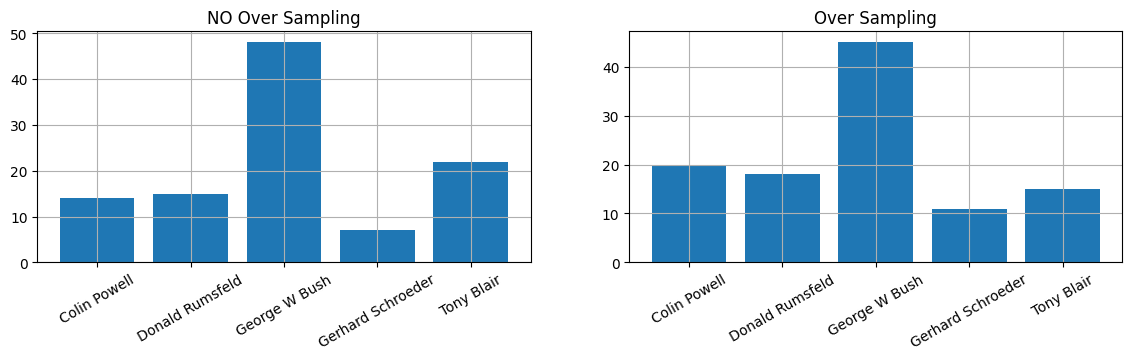

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(14, 3))
axs[0].set_title('NO Over Sampling')

axs[0].bar(np.arange(len(face_tnames)), [np.sum(cmat_fda[:,t]) -cmat_fda[t][t] for t in range(len(face_tnames))])
axs[0].set_xticks(np.arange(len(face_tnames)))
axs[0].set_xticklabels(face_tnames, rotation=30)
axs[0].grid()

axs[1].set_title('Over Sampling')

axs[1].bar(np.arange(len(face_tnames)), [np.sum(cmat_fda_ros[:,t]) - cmat_fda_ros[t][t] for t in range(len(face_tnames))])
axs[1].set_xticks(np.arange(len(face_tnames)))
axs[1].set_xticklabels(face_tnames, rotation=30)
axs[1].grid()

plt.show()